## This notebook is used to generate synthetic data of the format:  {sequence of characters that implement the desired task} - {desired task described in natural language}

base.txt file was created by myself and it has (hopefully) all the vim commands with description.

In [1]:
import pandas as pd

df = pd.read_csv('base.txt', sep=r'\s–\s', engine='python', names=['key', 'description'])
print(f'Total number of commands = {df.shape[0]}')
df.sample(5)

Total number of commands = 89


,key,description
52,o,move from one end of the selected text to the ...
88,@@,run last macro again
12,^,jump to the first (non-blank) character of the...
27,a,switch to insert mode after the cursor
1,j,move the cursor down


## Now I will use gpt4o with web-search to generate different scenarios of usages for each command

In [2]:
cmd = f'{df.iloc[6].key}:  {df.iloc[6].description}'
cmd

'w:  move to the start of the next word'

In [ ]:
querry = f'''Generate 20 different and diverse vim motions sequences for different scenarios including the following command: {str('{') + cmd + str('}')}
Your answers should inlucde both simple and complex sequences and cover all casual situatios that may require using the given command. Your examples might also inlucde sequences using other commands with the combination of given command

for example for the command {{d: delete (cut) the marked text}} you would write: 

{{dw: delete word}},
{{dW: delete WORD}},
etc...

Your answer should be in the following format and not include anything except the commands and scenarios:
{{command1: description1}},
{{command2: description2}}

'''

In [ ]:
from openai import OpenAI
client = OpenAI(api_key='there was my key')

completion = client.chat.completions.create(
    model="gpt-4o-mini-search-preview",
    messages=[
        {
            "role": "user",
            "content": querry
        }
    ]
)

print(completion.choices[0].message.content)

{w: move to the start of the next word},
{2w: move to the start of the second next word},
{3w: move to the start of the third next word},
{w$: move to the start of the next word and delete to the end of the line},
{dww: delete the current word and the next word},
{d2w: delete the current word and the second next word},
{d3w: delete the current word and the third next word},
{cw: change the current word},
{c2w: change the current word and the next word},
{c3w: change the current word and the second next word},
{yw: yank the current word},
{y2w: yank the current word and the next word},
{y3w: yank the current word and the second next word},
{d3w: delete the current word and the next two words},
{d3w$: delete the current word and the next two words to the end of the line},
{d3w0: delete the current word and the next two words to the beginning of the line},
{d3w^: delete the current word and the next two words to the first non-blank character of the line} 


In [5]:
import re

def parse_commands(commands_str: str, df: pd.DataFrame = None) -> pd.DataFrame:

    pattern = r"\{([^}]+)\}"
    matches = re.findall(pattern, commands_str)
    
    for match in matches:
        if ":" in match:
            key, description = match.split(":", 1)
            key = key.strip()
            description = description.strip()
            df.loc[len(df)] = [key, description]
            
    return df

In [ ]:
# just testing

df_test = pd.DataFrame(columns=["key", "description"])
answer = completion.choices[0].message.content

df_test = parse_commands(answer, df_test)
df_test

,key,description
0,w,move to the start of the next word
1,2w,move to the start of the second next word
2,3w,move to the start of the third next word
3,w$,move to the start of the next word and delete ...
4,dww,delete the current word and the next word
5,d2w,delete the current word and the second next word
6,d3w,delete the current word and the third next word
7,cw,change the current word
8,c2w,change the current word and the next word
9,c3w,change the current word and the second next word


In [8]:
def get_prompt(cmd):
    
    prompt = f'''Generate 20 different and diverse vim motions sequences for different scenarios including the following command: {str('{') + cmd + str('}')}
    Your answers should inlucde both simple and complex sequences and cover all casual situatios that may require using the given command. Your examples might also inlucde sequences using other commands with the combination of given command

    for example for the command {{d: delete (cut) the marked text}} you would write: 

    {{dw: delete word}},
    {{dW: delete WORD}},
    etc...

    Your answer should be in the following format and not include anything except the commands and scenarios:
    {{command1: description1}},
    {{command2: description2}}

    '''
    
    return prompt

In [9]:
from tqdm import tqdm

def generate_dateset(base_df, output_df):
    for i in tqdm(range(base_df.shape[0]), desc="Processing commands"):
        cmd = f'{base_df.iloc[i].key}:  {base_df.iloc[i].description}'
        prompt = get_prompt(cmd)
        
        completion = client.chat.completions.create(
            model="gpt-4o-mini-search-preview",
            messages=[
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        )
        answer = completion.choices[0].message.content 
        output_df = parse_commands(answer, output_df)
        
    return output_df


In [10]:
df_synthetic = df.copy() # synthetic data also includes original commands

In [11]:
df_synthetic = generate_dateset(df, df_synthetic)

Processing commands: 100%|██████████| 89/89 [11:39<00:00,  7.86s/it]


## Brief look at the results

In [12]:
df_synthetic.shape[0]

3304

In [13]:
df_synthetic.sample(10)

,key,description
2280,*yW,yank the current WORD
655,dE3w,delete to the end of the third word
2099,di[,delete inside square brackets
3197,dT',delete to just before previous occurrence of '''
1207,O30,open a new line above the current one and move...
2140,di{,delete inside curly braces
122,h3G,move the cursor left to the beginning of the t...
2933,d$,delete to end of line
339,"Ctrl+w, H",move the current window to the far left
796,y^,yank from the cursor position to the first non...


In [16]:
df_synthetic.to_csv('data_raw.csv', index=False)

In [63]:
df_synthetic[df_synthetic.duplicated()].shape[0]

1321

In [ ]:
# deleting duplicates
df_synthetic.drop_duplicates(inplace=True)

In [66]:
df_synthetic.shape[0]

1983

In [67]:
df_synthetic.to_csv('data_unuqie_raw.csv', index=False)

I also visually inspected the data and manually deleted artefacts so i need to re-read the file

In [12]:
df_synthetic = pd.read_csv('data_unuqie_clean.csv')

## Now i will validate and correct some commands using o1-mini

In [13]:
cmd = f'{df_synthetic.iloc[7].key} - {df_synthetic.iloc[7].description}'
cmd

'W - move to the start of the next token'

In [14]:
def get_prompt(cmd):
    
    prompt = f'''NOTE: token is the same as WORD - sequence of non-whitespace characters
    If the wollowing vim command is correct - wrtie only 'yes'. If it is incorrect - write only the '{{correct command}}'
    {cmd}
    '''
    
    return prompt

In [15]:
querry = get_prompt(cmd)
querry

"NOTE: token is the same as WORD - sequence of non-whitespace characters\n    If the wollowing vim command is correct - wrtie only 'yes'. If it is incorrect - write only the '{correct command}'\n    W - move to the start of the next token\n    "

In [19]:
completion = client.chat.completions.create(
                model="o1-mini",
                messages=[
                    {
                        "role": "user",
                        "content": querry
                    }
                ],
                stream=False
            )

print(completion.choices[0].message.content)

yes


In [ ]:
def run_validation(df, validation_results=None, start_index=0):
    if validation_results is None:
        validation_results = []
    
    for i in tqdm(range(start_index, df.shape[0]), desc="Processing commands"):
        cmd = f'{df.iloc[i].key} - {df.iloc[i].description}'
        prompt = get_prompt(cmd)
        
        try:
            completion = client.chat.completions.create(
                model="o1-mini",
                messages=[
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                stream=False
            )
            answer = completion.choices[0].message.content 
            validation_results.append(answer)
        except Exception as e:
            print(f"API error encountered: {e}. Saving results")
            return validation_results
            
    return validation_results

In [27]:
validation_results = run_validation(df_synthetic, start_index=89)

Processing commands: 100%|██████████| 1384/1384 [1:46:31<00:00,  4.62s/it] 


In [28]:
import pickle

with open("validation_results.pkl", "wb") as f:
    pickle.dump(validation_results, f)

In [ ]:
validation_results_complete = ['yes' for _ in range(89)] + validation_results # first 89 rows are from base.txt and hence they are correct 

In [34]:
assert len(validation_results_complete) == df_synthetic.shape[0]

Correct commands that are marked as incorrect during validation

In [ ]:
for i, result in enumerate(validation_results_complete):

    if result == 'yes':
        continue

    if result.startswith('{') and result.endswith('}'):
        new_value = result[1:-1]
    else:
        new_value = result
    df_synthetic.at[i, 'key'] = new_value

df_synthetic.to_csv('data_validated.csv', index=False)

In [12]:
# did manual inspection and removed

df_synthetic = pd.read_csv('data_validated.csv')

In [13]:
df_synthetic.drop_duplicates(inplace=True, ignore_index=True)
df_synthetic.to_csv('data_validated.csv', index=False)

In [14]:
df_synthetic['count'] = df_synthetic.groupby('key')['key'].transform('count')

In [15]:
df_synthetic.sort_values('count', ascending=False)

,key,description,count
263,d$,delete from the cursor position to the end of ...,13
709,d$,delete the selected lines from the cursor posi...,13
241,d$,Delete from the cursor position to the end of ...,13
207,d$,delete to the end of the line,13
243,d$,Delete from the cursor position to the end of ...,13
...,...,...,...
607,d/<pattern>,delete from the cursor to the next occurrence ...,1
613,d4k,delete the current line and the previous four ...,1
616,dt.,delete up to but not including the next period,1
617,d/word/e,delete up to and including the next occurrence...,1


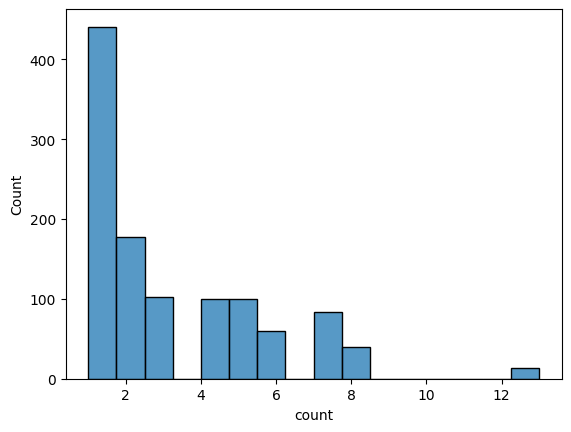

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_synthetic['count'])
plt.show()

Currently there is clear disbalance in commands so I wil fix it by the following schema:

- if command is met less than 4 times generate a few more paraphrases for the existing description
- else just skip it

In [32]:
def get_prompt(phrase, x):
    prompt = (
        "I am preparing a dataset to train a language model on short textual 'scenarios' describing commands used in Vim.\n"
        "Your task is to rephrase these scenarios without losing any essential information or changing any command references.\n\n"
        f"Generate {x} distinct paraphrases for the following scenario:\n"
        f"\"{phrase}\"\n\n"
        "Follow these rules strictly:\n"
        "1. Preserve the full meaning and keep all key/command references accurate.\n"
        "2. Avoid using complex words or structures.\n"
        "3. Each paraphrase must be on its own line.\n"
        "4. Do not end any line with punctuation.\n"
        "5. Output only the paraphrases, and nothing else."
    )
    return prompt


In [33]:
get_prompt(df_synthetic.iloc[521]['description'], 3)

'I am preparing a dataset to train a language model on short textual \'scenarios\' describing commands used in Vim.\nYour task is to rephrase these scenarios without losing any essential information or changing any command references.\n\nGenerate 3 distinct paraphrases for the following scenario:\n"delete to beginning of file"\n\nFollow these rules strictly:\n1. Preserve the full meaning and keep all key/command references accurate.\n2. Avoid using complex words or structures.\n3. Each paraphrase must be on its own line.\n4. Do not end any line with punctuation.\n5. Output only the paraphrases, and nothing else.'

In [34]:
prompt = get_prompt(df_synthetic.iloc[521]['description'], 3)

completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            stream=False
        )

completion.choices[0].message.content.strip()

"remove text up to the start of the file  \nerase content until the file's beginning  \nclear everything to the top of the file"

I need to get df with unque keys and iterate over it because if I use non unique I will end up generating (4 - count) examples for each occurance of the key which is not what I want, because I want total 4 descriptions for each key

In [39]:
df_synthetic_unique = df_synthetic.drop_duplicates(subset=['key'], keep='first')

In [ ]:
new_rows = []

for index, row in tqdm(df_synthetic_unique.iterrows(), total=len(df_synthetic), desc="Enriching Data"): # i just noticed that total = len(df_synthetic) but not len(df_synthetic_unique) but anyway...
    phrase = row["description"]
    count = row["count"]
    
    if count < 4:
        num_new_paraphrases = 4 - count
        prompt = get_prompt(phrase, num_new_paraphrases)
        
        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            stream=False
        )
        
        answer = completion.choices[0].message.content.strip()
        paraphrases = answer.split("\n")
        
        for p in paraphrases:
            new_rows.append({"key": row["key"], "description": p})

df_enriched = pd.DataFrame(new_rows, columns=["key", "description"])

Enriching Data:  57%|█████▋    | 637/1118 [11:47<08:54,  1.11s/it]


In [ ]:
df_final = pd.concat([df_synthetic.drop(columns=["count"]), df_enriched], ignore_index=True)
df_final.to_csv('final.csv', index=False)

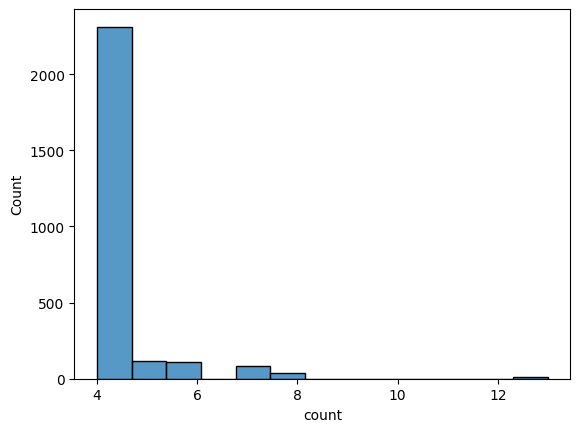

In [43]:
df_final['count'] = df_final.groupby('key')['key'].transform('count')
sns.histplot(df_final['count'])
plt.show()

ok that seems reasonable

In [44]:
df_final.shape[0]

2672

In [62]:
df_final[df_final['description'] == ''].shape[0]

19

In [63]:
df_final = df_final[df_final['description'] != '']
df_final.to_csv('final.csv', index=False)

In [66]:
# again did some manual changes
df_final = pd.read_csv('final.csv', usecols=['key', 'description'])

In [67]:
df_final[df_final['key'].str.contains(" ", na=False)]

,key,description
237,0f; $,Move to the next occurrence of ';' on the curr...
344,L ciw,"move to the bottom of the screen, then change ..."
347,L di(,"move to the bottom of the screen, then delete ..."
371,IHello World,insert 'Hello World' at the beginning of the line
718,"Ctrl+v, I",insert text at the beginning of each line in t...
...,...,...
2519,2 Ctrl-i,go to the jump two spaces ahead
2520,2 Ctrl-i,advance to the next jump after the first one
2545,":.,'a c",modify text from this line to the line marked ...
2546,":.,'a c",replace content from the current line to the l...


In [ ]:
# I have noticed that sometimes in key there is Ctrl+v and sometimes it is written as <C-v> and sometimes as Ctrl-v. Here I change all to first notation

df_final['key'] = df_final['key'].str.replace(r'<C-([A-Za-z])>', lambda m: f"Ctrl+{m.group(1)}", regex=True)
df_final['key'] = df_final['key'].str.replace(r'Ctrl-([A-Za-z])', lambda m: f"Ctrl+{m.group(1)}", regex=True)

df_final.to_csv('final.csv', index=False)

In [ ]:
# finally sometimes there are whitespaces where they dont need to be so I delete them (keep only where there is 'Ctrl')

mask = ~df_final['key'].str.contains("Ctrl", na=False)
df_final.loc[mask, 'key'] = df_final.loc[mask, 'key'].apply(lambda x: ''.join(x.split()))

In [81]:
df_final.to_csv('final.csv', index=False)